In [105]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


In [106]:
data = pd.read_csv('final_data.csv')
print(data.head())


   Unnamed: 0  patient_id    pr_display spo2_display resp_display  \
0           0        7001  90 beats/min          95%          20%   
1           1        7001  71 beats/min          96%          17%   
2           2        7001  71 beats/min          96%          17%   
3           3        7001  71 beats/min          96%          17%   
4           4        7001  71 beats/min          96%          17%   

   pulse_rate_obscount  pulse_rate_avg  pulse_rate_min  pulse_rate_max  \
0                 30.0           89.65           88.63           90.00   
1                 10.0           70.01           66.63           71.52   
2                 10.0           70.01           66.63           71.52   
3                 10.0           70.01           66.63           71.52   
4                 10.0           70.01           66.63           71.52   

   pulse_rate_iqr  ...  QC Deviation from median.1  \
0            0.58  ...                    0.054458   
1            2.88  ...          

In [107]:
print("Data shape:", data.shape)
print(data.info())
print("Missing values per column:\n", data.isnull().sum())


Data shape: (85795, 163)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85795 entries, 0 to 85794
Columns: 163 entries, Unnamed: 0 to Temperature_C
dtypes: float64(138), int64(3), object(22)
memory usage: 106.7+ MB
None
Missing values per column:
 Unnamed: 0           0
patient_id           0
pr_display           0
spo2_display         0
resp_display         0
                 ...  
Temperature      85784
SpO2             85782
BP               85782
HR               85782
Temperature_C    85784
Length: 163, dtype: int64


In [108]:
date_columns = ['Date of CAR-T infusion', 'datetime', 'Date', 'date', 'Date of last response assesment']
for col in date_columns:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

In [109]:
data = data.sort_values(['patient_id', 'datetime'])




In [110]:
agent_column = 'Agent (JNJ/BMS/Caribou)'  # Replace with your actual column name if different


print("Data shape after filtering for agents containing 'JNJ':", data.shape)
print("Unique patient IDs after filtering:", data['patient_id'].unique())

Data shape after filtering for agents containing 'JNJ': (85795, 163)
Unique patient IDs after filtering: [7001 7002 7003 7004 7005 7006 7007 7008]


In [111]:
baseline_features = ['pulse_rate_avg', 'spo2_avg', 'respiratory_rate_avg', 'covered_skin_temperature_avg']
# Compute baseline values before CAR-T infusion
baseline_data = data[data['datetime'] < data['Date of CAR-T infusion']]


In [112]:
baseline = baseline_data.groupby('patient_id')[baseline_features].mean().reset_index()
baseline = baseline.rename(columns={feature: feature + '_baseline' for feature in baseline_features})

In [113]:
data = pd.merge(data, baseline, on='patient_id', how='left')
print("Data shape after filtering for JNJ:", data.shape)

Data shape after filtering for JNJ: (85795, 167)


In [114]:
for feature in baseline_features:
    baseline_feature = feature + '_baseline'
    delta_feature = feature + '_delta'
    data[delta_feature] = data[feature] - data[baseline_feature]

cytokine_columns = ['IL8', 'TNFRSF9', 'TIE2', 'MCP-3', 'CD40-L', 'IL-1 alpha', 'CD244', 'EGF', 'ANGPT1', 'IL7',
                    'PGF', 'IL6', 'ADGRG1', 'MCP-1', 'CRTAM', 'CXCL11', 'MCP-4', 'TRAIL', 'FGF2', 'CXCL9', 'CD8A',
                    'CAIX', 'MUC-16', 'ADA', 'CD4', 'NOS3', 'IL2', 'Gal-9', 'VEGFR-2', 'CD40', 'IL18', 'GZMH',
                    'KIR3DL1', 'LAP TGF-beta-1', 'CXCL1', 'TNFSF14', 'IL33', 'TWEAK', 'PDGF subunit B', 'PDCD1',
                    'FASLG', 'CD28', 'CCL19', 'MCP-2', 'CCL4', 'IL15', 'Gal-1', 'PD-L1', 'CD27', 'CXCL5', 'IL5',
                    'HGF', 'GZMA', 'HO-1', 'CX3CL1', 'CXCL10', 'CD70', 'IL10', 'TNFRSF12A', 'CCL23', 'CD5', 'CCL3',
                    'MMP7', 'ARG1', 'NCR1', 'DCN', 'TNFRSF21', 'TNFRSF4', 'MIC-A/B', 'CCL17', 'ANGPT2', 'PTN',
                    'CXCL12', 'IFN-gamma', 'LAMP3', 'CASP-8', 'ICOSLG', 'MMP12', 'CXCL13', 'PD-L2', 'VEGFA', 'IL4',
                    'LAG3', 'IL12RB1', 'IL13', 'CCL20', 'TNF', 'KLRD1', 'GZMB', 'CD83', 'IL12', 'CSF-1']
cytokine_columns = [col for col in cytokine_columns if col in data.columns]

In [115]:
time_window_size = '6H'
prediction_window_size = pd.Timedelta(hours=6)


crs_occurrences = data[data['CRS on date (0 No, 1 Yes)'] == 1][['patient_id', 'datetime']].drop_duplicates()

# Aggregate data into time windows and label
aggregated_data_list = []

In [116]:

crs_occurrences = data[data['CRS on date (0 No, 1 Yes)'] == 1][['patient_id', 'datetime']].drop_duplicates()

aggregated_data_list = []

for patient in data['patient_id'].unique():
    patient_df = data[data['patient_id'] == patient]
    patient_df = patient_df.set_index('datetime')


    numeric_cols = patient_df.select_dtypes(include=[np.number]).columns
    patient_windows = patient_df[numeric_cols].resample(time_window_size).mean()

    if 'Age' in patient_df.columns:
        patient_windows['Age'] = patient_df['Age'].resample(time_window_size).ffill()
    if 'Dose (10^6 cells/kg)' in patient_df.columns:
        patient_windows['Dose (10^6 cells/kg)'] = patient_df['Dose (10^6 cells/kg)'].resample(time_window_size).ffill()
    patient_windows['patient_id'] = patient
    patient_windows = patient_windows.reset_index()

    # Label each window
    patient_crs_times = crs_occurrences[crs_occurrences['patient_id'] == patient]['datetime']
    patient_windows['CRS'] = 0
    for idx in patient_windows.index:
        window_end = patient_windows.loc[idx, 'datetime'] + pd.Timedelta(time_window_size)
        prediction_window_end = window_end + prediction_window_size
        # Check if any CRS occurrence time is within [window_end, prediction_window_end)
        crs_in_window = patient_crs_times[(patient_crs_times >= window_end) & (patient_crs_times < prediction_window_end)]
        if not crs_in_window.empty:
            patient_windows.loc[idx, 'CRS'] = 1
    aggregated_data_list.append(patient_windows)

aggregated_data = pd.concat(aggregated_data_list, ignore_index=True)

aggregated_data = aggregated_data.fillna(method='ffill').fillna(method='bfill')

delta_features = [col for col in aggregated_data.columns if '_delta' in col]
additional_features = ['Age', 'Dose (10^6 cells/kg)'] + cytokine_columns
features = delta_features + [feat for feat in additional_features if feat in aggregated_data.columns]

aggregated_data = aggregated_data.dropna(subset=features + ['CRS'])
X = aggregated_data[features]
y = aggregated_data['CRS']

In [117]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets using time-based splitting
aggregated_data['datetime'] = pd.to_datetime(aggregated_data['datetime'])
aggregated_data = aggregated_data.sort_values('datetime')

# Define cutoff date for training and testing
cutoff_date = aggregated_data['datetime'].quantile(0.8)

# Training data
train_data = aggregated_data[aggregated_data['datetime'] <= cutoff_date]
X_train = train_data[features]
y_train = train_data['CRS']

# Testing data
test_data = aggregated_data[aggregated_data['datetime'] > cutoff_date]
X_test = test_data[features]
y_test = test_data['CRS']

# Handle imbalanced data using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Standardize features after resampling
X_train_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Model training with XGBoost
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42)

In [118]:
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Best model
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

# Predictions on test set
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]



Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


Accuracy: 0.9178082191780822
ROC AUC Score: 0.3001760563380282

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       284
           1       0.06      0.12      0.08         8

    accuracy                           0.92       292
   macro avg       0.52      0.53      0.52       292
weighted avg       0.95      0.92      0.93       292



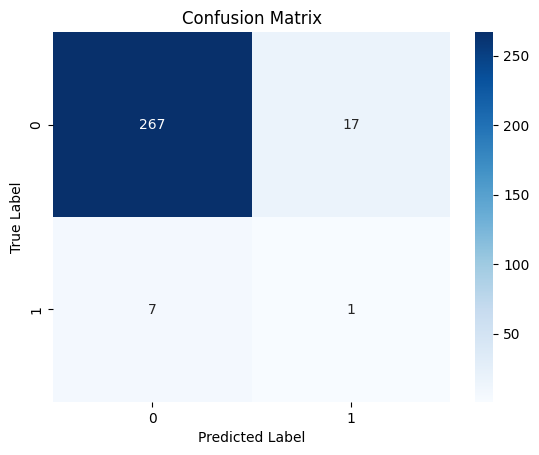

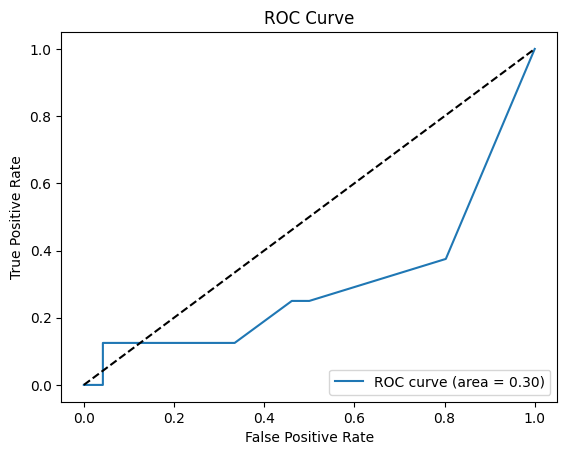

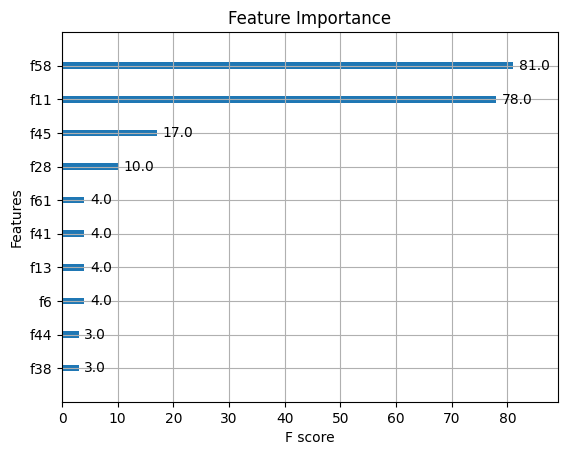

In [119]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, roc_curve

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature importance
from xgboost import plot_importance

plot_importance(best_model, max_num_features=10)
plt.title('Feature Importance')
plt.show()

In [122]:
# ------------------ Testing the Model on a Specific Patient ------------------

# Replace with the patient ID you want to test
patient_id_to_test = 7005  # Example patient ID

# Extract the patient's data
patient_data = data[data['patient_id'] == patient_id_to_test].copy()

# Ensure datetime is in datetime format and sorted
patient_data['datetime'] = pd.to_datetime(patient_data['datetime'])
patient_data = patient_data.sort_values('datetime')

# Calculate delta features for the patient
for feature in baseline_features:
    baseline_feature = feature + '_baseline'
    delta_feature = feature + '_delta'
    patient_data[delta_feature] = patient_data[feature] - patient_data[baseline_feature]

# Handle missing delta features
delta_features = [feature + '_delta' for feature in baseline_features]
patient_data = patient_data.dropna(subset=delta_features)

# Aggregate data into time windows
patient_data = patient_data.set_index('datetime')

# Resample into time windows (same as during training)
patient_windows = patient_data.resample(time_window_size).mean().reset_index()

# Handle missing values
patient_windows = patient_windows.fillna(method='ffill').fillna(method='bfill')

# Ensure the features are the same as used in training
test_features = features  # Use the same features as during training

missing_features = set(test_features) - set(patient_windows.columns)
if missing_features:
    print(f"The following features are missing in the patient's data: {missing_features}")
    for feature in missing_features:
        patient_windows[feature] = 0  # Or use mean values, etc.

patient_windows = patient_windows[test_features]

patient_windows_scaled = scaler.transform(patient_windows)

patient_predictions = best_model.predict(patient_windows_scaled)
patient_pred_proba = best_model.predict_proba(patient_windows_scaled)[:, 1]

patient_windows['CRS_prediction'] = patient_predictions
patient_windows['CRS_prediction_probability'] = patient_pred_proba

print(f"Predictions for Patient ID: {patient_id_to_test}")
print(patient_windows[['datetime', 'CRS_prediction', 'CRS_prediction_probability']])


ValueError: Found array with 0 sample(s) (shape=(0, 97)) while a minimum of 1 is required by StandardScaler.